In [3]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, md5
import matplotlib.pyplot as plt

# Initialize Spark Session with the specified application name
spark = SparkSession.builder.appName("Test_grandata").getOrCreate()

# Example to confirm Spark session by creating a simple range dataframe and showing the result
spark.range(10).show()

# Define file paths for the datasets
events_csv_path = "/home/jovyan/datasets/events.csv.gz"
free_sms_destinations_csv_path = "/home/jovyan/datasets/free_sms_destinations.csv.gz"

# Read the CSV files into DataFrames with header and inferred schema
df_events = spark.read.csv(events_csv_path, header=True, inferSchema=True)
df_destinations = spark.read.csv(free_sms_destinations_csv_path, header=True, inferSchema=True)

# Display the first 10 rows of each DataFrame to verify data loading
df_events.show(10)
df_destinations.show(10)

# Create temporary views for SQL queries
df_events.createOrReplaceTempView("events")
df_destinations.createOrReplaceTempView("free_sms_destinations")


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+

+----+-----+-------+---+--------+------+---------+--------------+
|hour|calls|seconds|sms|    date|region|id_source|id_destination|
+----+-----+-------+---+--------+------+---------+--------------+
|  11|    1|     24|  0|20211001|     5|      BF3|           374|
|   1|    1|     51|  0|20211001|     4|      9F5|           374|
|  11|    1|      3|  0|20211001|     6|      025|           374|
|  10|    1|     36|  0|20211001|     5|      FB6|           D52|
|  23|    4|    137|  0|20211001|     8|      4BB|           861|
|  18|    0|      0|  1|20211001|     4|      90C|           5B0|
|  13|    1|    618|  0|20211001|     9|      7AB|           4CA|
|  16|    1|    172|  0|20211001|     9|      7AB|           4CA|
|   6|    1|    208|  0|20211001|     9|      7AB|           4CA|
|   5|    1|     66|  0|20211001|     9|      7AB|           4CA|
+----+-----+-------+---+--------+------+---------+-------

In [4]:

# Calculates the total billing cost for the company.
df_costo_total = spark.sql(f""" SELECT 
                            SUM( CASE 
                                    WHEN CAST(region AS INT) BETWEEN 1 AND 5 THEN 1.5
                                    WHEN CAST(region AS INT) BETWEEN 6 AND 9 THEN 2
                                    ELSE 0 
                                END ) AS costo_total
                            FROM events
                            LEFT JOIN free_sms_destinations ON events.id_destination = free_sms_destinations.id
                            WHERE free_sms_destinations.id IS NULL 
                            AND id_destination IS NOT NULL 
                            AND id_source IS NOT NULL
                                        """)

df_costo_total.show()

+-----------+
|costo_total|
+-----------+
|  1696022.5|
+-----------+



In [5]:
# We group by id_source, sum their costs, order by the result, and keep the top 100
# Exclude rows where id is null and also those where the message sending cost is zero

df_costo_usuario = spark.sql(f""" SELECT md5(id_source) AS ID_SOURCE,
                            SUM( CASE 
                                    WHEN CAST(region AS INT) BETWEEN 1 AND 5 THEN 1.5
                                    WHEN CAST(region AS INT) BETWEEN 6 AND 9 THEN 2
                                    ELSE 0 
                                END ) AS costo
                            FROM events
                            LEFT JOIN free_sms_destinations ON events.id_destination = free_sms_destinations.id
                            WHERE free_sms_destinations.id IS NULL 
                            AND id_destination IS NOT NULL 
                            AND id_source IS NOT NULL
                     GROUP BY id_source
                     ORDER BY costo desc 
                     LIMIT 100
                                        """)
df_costo_usuario.show()                  

# Write the output as a Parquet file with gzip compression
df_costo_usuario.write.mode("overwrite").parquet("/home/jovyan/data/parquet", compression="gzip")


+--------------------+-------+
|           ID_SOURCE|  costo|
+--------------------+-------+
|911914c7729eedbdf...|18573.0|
|bd180b7811395cbce...|13508.0|
|14a0660ae2f5d1868...| 4070.0|
|16c222aa19898e505...| 1707.0|
|bc97b32ee2abb9c18...| 1292.5|
|6a57072949dbc409c...| 1026.0|
|f5a45e33602ea62f9...| 1023.5|
|e9d076deb3451cc49...| 1015.5|
|1b2e80021b5fc82bf...|  892.0|
|159e1f3d6ff0e7c3c...|  714.5|
|4e321438558549248...|  702.0|
|aeb3135b436aa5537...|  680.0|
|496ce5f942d15eefb...|  652.0|
|beed13602b9b0e6ec...|  626.5|
|aa35b36e4d1395542...|  616.0|
|e87c495061191f4df...|  611.5|
|2823f4797102ce1a1...|  610.5|
|11b921ef080f77360...|  605.5|
|13d8d90116cbacd3a...|  603.5|
|49159f42b0f043d6d...|  592.5|
+--------------------+-------+
only showing top 20 rows



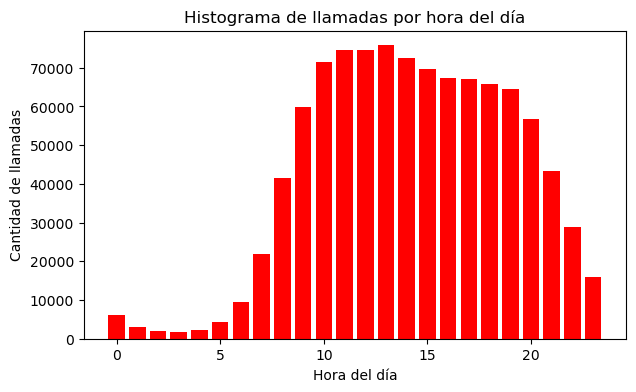

In [9]:
# Group the calls by hour
llamadas_por_hora_df = df_events.groupBy("hour").count()

# Convert to a Pandas DataFrame for plotting
pd_df = llamadas_por_hora_df.toPandas()

# Sort by hour
pd_df.sort_values("hour", inplace=True)

# Plot the data
plt.figure(figsize=(7,4))
plt.bar(pd_df["hour"], pd_df["count"], color='red')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de llamadas')
plt.title('Histograma de llamadas por hora del día')
plt.savefig('/home/jovyan/data/histograma_calls_per_hour.png')